# Example: Polynomial function


The following is an example of history matching with the
iterative_ensemble_smoother library.

## Setup

The setup contains a forward model (a second degree polynomial in this case),
where the coefficents of the polynomial is the model parameters.

There are 5 time steps t=0,1,2,3,4 and 3 observations at t=0,2,4.

In [1]:
import numpy as np

number_of_observations = 3
number_of_time_steps = 5
observation_times = np.array([0, 2, 4])
number_of_realizations = 100

Before history matching, these observations are predicted by the forward
model with the priors. In this case a polynomial function:

In [2]:
def forward_model(model_parameters):
    """Our :term:`forward_model` is s_0 * t**2 + s_1 * t + s_2 where s_0,
    s_1,s_2 is the model parameters and t is the time.
    """
    return np.array(
        [
            sum(
                parameter * time ** (2 - i)
                for i, parameter in enumerate(model_parameters)
            )
            for time in range(number_of_time_steps)
        ]
    )

We create some simple plotting of forward-model with a single response
and parameters. The plots show the responses as a linegraph on the left,
and the distribution of the parameters towards the right.

In [3]:
from matplotlib import pyplot as plt


def plot_result(A, responses, priors):
    if priors is None:
        priors = []
    plt.rcParams["figure.figsize"] = [15, 4]
    _, axs = plt.subplots(1, 1 + len(A))

    axs[0].plot(range(number_of_time_steps), responses)
    for i, param in enumerate(A):
        A_trans = np.array([priors[i](v) for v in param])
        axs[i + 1].hist(A_trans, bins=10)
    plt.show()

We require a transformation of standard guassian random
variables (which arise from the algorithm) to uniformly
distributed variables inside an interval.

In [4]:
from math import sqrt

from scipy.special import erf


def guassian_to_uniform(min_x, max_x):
    """Maps a standard guassian random variable
        to random variable, uniformly distributied between
        min_x and max_x.
    :param min_x: The lower bound on the returned value.
    :param max_x: The upper bound on the returned value.
    """

    def random_variable(x):
        """maps standard normal random outcome x to
        uniform outcome between min_x and max_x.
        """
        y = 0.5 * (1 + erf(x / sqrt(2.0)))
        return y * (max_x - min_x) + min_x

    return random_variable

The priors at t=0,2,4 are assumed uniform in [0,1], [0,2] and [0,5]
respectively.

In [5]:
priors = [
    guassian_to_uniform(0, 1),
    guassian_to_uniform(0, 2),
    guassian_to_uniform(0, 5),
]

As input to the history matching we have the observed values in
`observation_values`. These would normally be historic measurements.

In [6]:
observation_values = np.array(
    [2.8532509308, 7.20311703432, 21.3864899107, 31.5145559347, 53.5676660405]
)

The observed values have the measurement errors in `observation_errors`.
A is populated with initial guesses for the parameters of the ensemble.

As input to the history matching we have the following
observed values. These would normally be historic measurements.

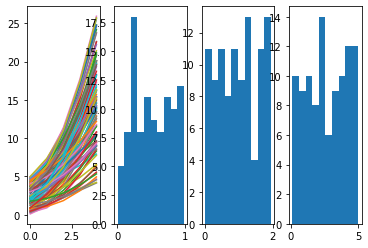

In [7]:
observation_values = np.array([2.8532509308, 7.20311703432, 21.3864899107])
# The observed values have the following measurement errors
observation_errors = np.array([0.5 * (x + 1) for x, _ in enumerate(observation_values)])
# The A matrix of model parameters is initially randomly generated
A = np.random.normal(0, 1, size=(3, number_of_realizations))

responses = forward_model([prior(x) for prior, x in zip(priors, A)])

plot_result(A, responses, priors)

The above plot shows our initial forward models on the left, and the
distribution of parameters towards the right.

## Update step
Now we perform one update step using the ensemble smoother algorithm

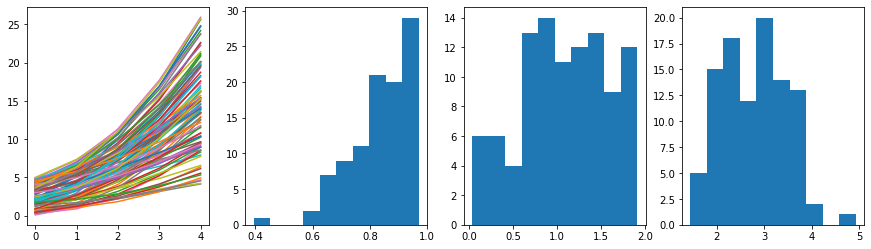

In [8]:
import iterative_ensemble_smoother as ies

new_A = ies.ensemble_smoother_update_step(
    responses[observation_times], A, observation_errors, observation_values
)
plot_result(new_A, responses, priors)

The plot shows that the distribution of the parameters has changed and the
forward models are now more consentrated around the measurements.

## Iterative smoother
We can also perform an update using the iterative ensemble smoother. The
following performs 4 update steps, and plots the resulting ensemble for
each step.

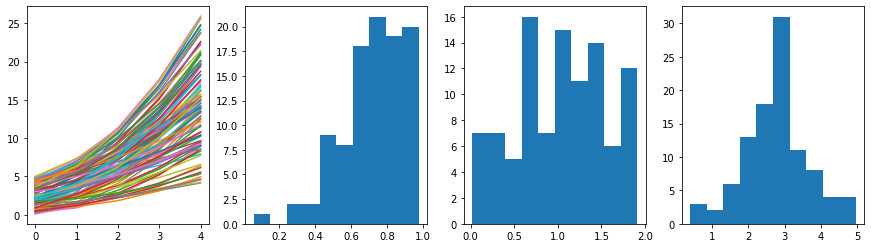

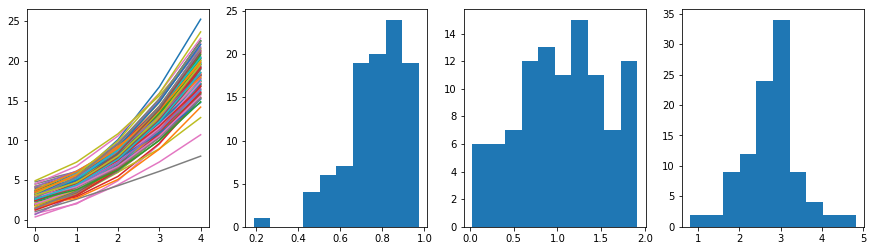

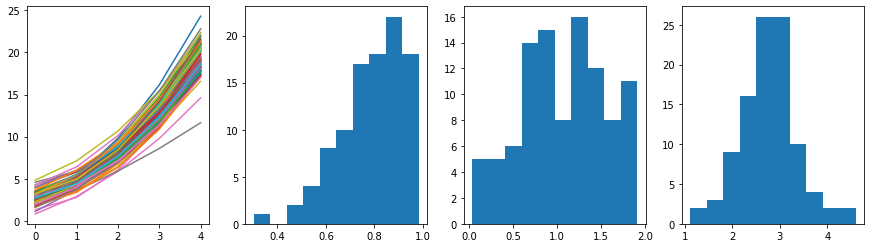

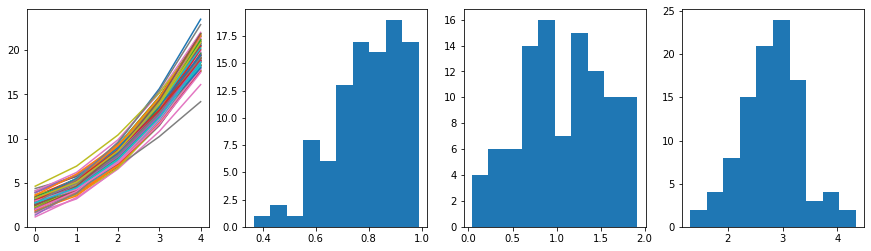

In [9]:
smoother = ies.IterativeEnsembleSmoother(number_of_realizations)
A_current = np.copy(A)

# The iterative smoother requires that A is in fortran order.
for _ in range(4):
    responses = forward_model([prior(x) for prior, x in zip(priors, A_current)])
    A_current = smoother.update_step(
        responses[observation_times],
        A_current,
        observation_errors,
        observation_values,
    )
    plot_result(A_current, responses, priors)


## ES-MDA
We can also perform an update using the ES-MDA (Multiple Data Assimilation -
Ensemble Smoother). The following performs 4 update steps, and plots 
the resulting ensemble for each step.

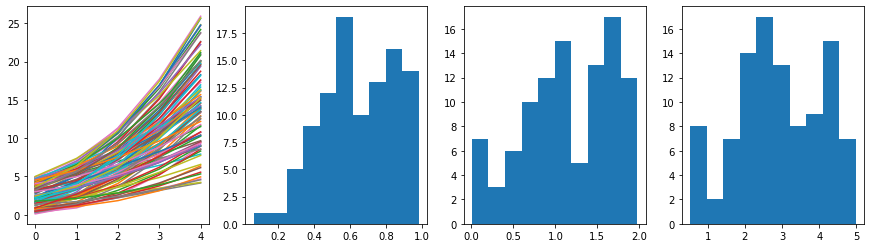

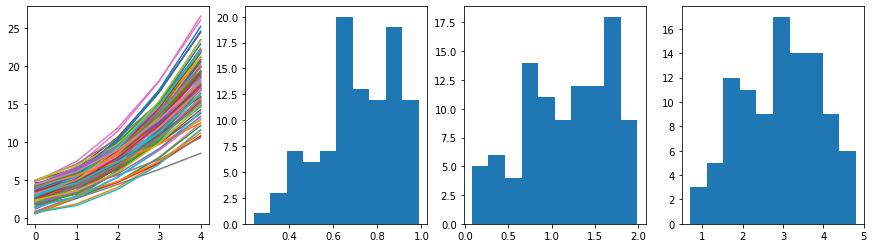

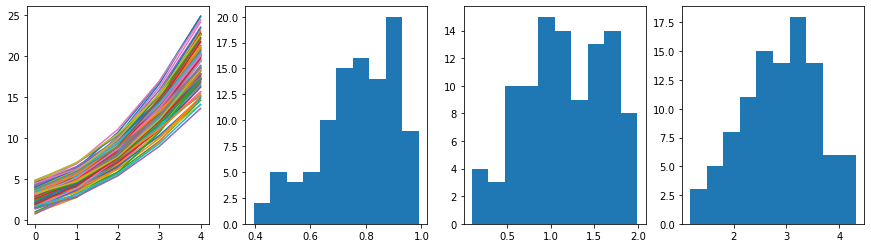

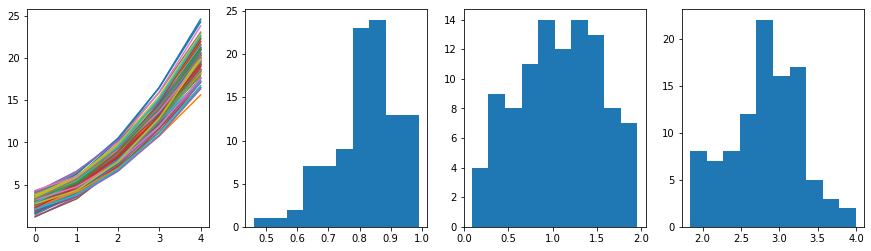

In [10]:
smoother = ies.IterativeEnsembleSmoother(number_of_realizations)
A_current = np.copy(A)

weights = [8, 4, 2, 1]
length = sum(1.0 / x for x in weights)
for weight in weights:
    responses = forward_model([prior(x) for prior, x in zip(priors, A_current)])
    observation_errors_scaled = observation_errors*sqrt(weight*length)
    A_current = ies.ensemble_smoother_update_step(
        responses[observation_times], A_current, observation_errors_scaled, observation_values
        )
    plot_result(A_current, responses, priors)